<a href="https://colab.research.google.com/github/ibacaraujo/fastai-deep-learning-from-the-foundations/blob/master/lesson8_assigned_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 8 Assigned Homework

* Review concepts from Course 1 (lessons 1 - 7): Affine Functions & 
non-linearities; Parameters & activations; Random initialization & transfer learning; SGD Momentum Adam (not sure what this one is, Jeremy's head covers it in the video); Convolutions; Batch-norm; Dropout; Data augmentation; Weight decay; Res/dense blocks; Image classification and regression; Embeddings; Continuous & Categorical variables; Collaborative filtering; Language models; NLP classification; Segmentation; U-net; GANS
* Make sure you understand broadcasting
* Read section 2.2 in Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
* Try to replicate as much of the notebooks as you can without peeking; when you get stuck, peek at the lesson notebook, but then close it and try to do it yourself

## Get data

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
from torch import tensor

In [15]:
MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
nrows, ncols = x_train.shape

In [23]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
img = x_train[0]

In [25]:
img.view(28, 28).type()

'torch.FloatTensor'

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

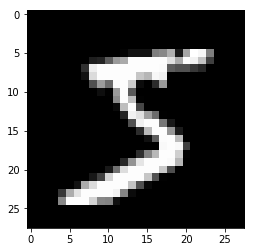

In [28]:
plt.imshow(img.view(28,28))

## Initial Python model

In [0]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [0]:
def matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    for j in range(b_ncols):
      for k in range(a_ncols):
        c[i, j] += a[i,k] * b[k,j]

  print(c.shape)
  print(c)

  return c

In [0]:
m1 = x_train[:5]
m2 = weights

In [36]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [53]:
t = matmul(m1, m2)

torch.Size([5, 10])
tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1217,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])


In [42]:
t

tensor([[ 71.8668,  77.7240, 129.9778, 159.6739, 127.4917, 118.3675, 127.5454,
          69.2612, 145.5829,  87.3750],
        [ 85.8121,  91.6693, 143.9231, 173.6191, 141.4370, 132.3129, 141.4908,
          83.2065, 159.5282, 101.3204],
        [ 40.2965,  46.1537,  98.4074, 128.1036,  95.9213,  86.7972,  95.9751,
          37.6909, 114.0125,  55.8047],
        [ 31.2809,  37.1380,  89.3918, 119.0880,  86.9057,  77.7816,  86.9594,
          28.6752, 104.9969,  46.7890],
        [ 55.0269,  60.8842, 113.1379, 142.8340, 110.6518, 101.5277, 110.7056,
          52.4213, 128.7430,  70.5352]])

In [0]:
# elementwise matmul
def elementwise_matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    for j in range(b_ncols):
      c[i,j] = (a[i,:] * b[:,j]).sum()
    
  print(c.shape)
  print(c)

  return c

In [57]:
t2 = elementwise_matmul(m1, m2)

torch.Size([5, 10])
tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1217,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])


In [66]:
t2

tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1217,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])

In [0]:
a = tensor([10., 20, 30])

In [59]:
a.shape

torch.Size([3])

In [60]:
a.unsqueeze(-1).shape

torch.Size([3, 1])

In [0]:
# broadcast_matmul
def broadcast_matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)

  print(c.shape)
  print(c)

  return c

In [64]:
t3 = broadcast_matmul(m1, m2)

torch.Size([5, 10])
tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1217,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])


In [65]:
t3

tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1217,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])

In [0]:
# Einstein summation matmul
def einstein_matmul(a, b):
  return torch.einsum('ik,kj->ij', a, b)

In [0]:
t4 = einstein_matmul(m1, m2)

In [69]:
t4

tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1218,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])

In [0]:
# PyTorch matmul
t5 = m1.matmul(m2)

In [71]:
t5

tensor([[ -1.0592, -12.4946, -12.0338,  -6.5528,  -1.7379, -16.5611,   9.2848,
           7.1576,  -4.1207,  -6.9489],
        [ -4.5072, -15.5858, -15.4199,   2.8232,  10.5785, -15.5846,   4.4661,
         -19.8433,   0.1218,  -5.0144],
        [  2.8217,   2.0356,  -3.7009,   1.1993,  -5.0093,   3.5292,   6.6322,
          -9.4532, -15.8133,  -3.1258],
        [  2.1719,  -0.4643,  -7.4518,  10.7623,   6.6971,  -3.5970,  -8.0052,
         -10.7011,  -3.4443, -12.2180],
        [  0.6295,   5.7265,  -2.2374,   6.0371, -11.9504, -12.0825,   5.4980,
          -3.3332, -14.6333,  -2.6428]])